# AT&T — Détection de SPAM SMS (Deep Learning)

Notebook en français (PyTorch) pour classifier des SMS en **spam** ou **ham** à partir du contenu.

**Livrable** : prétraitement + entraînement deep learning + performance clairement affichée (Accuracy, Precision, Recall, F1 + matrice de confusion).

## 1. Imports et paramètres

In [2]:

import re
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cpu")
torch.set_num_threads(1)

print("PyTorch:", torch.__version__)
print("Device :", device)


PyTorch: 2.9.1
Device : cpu


## 2. Chargement et inspection rapide

Le dataset contient typiquement `v1` (label) et `v2` (texte). On garde uniquement ces colonnes.

In [3]:

DATA_PATH = "spam.csv"  # le fichier doit être dans le même dossier que ce notebook

df = pd.read_csv(DATA_PATH, encoding="latin-1")
df = df[["v1", "v2"]].rename(columns={"v1": "label", "v2": "text"})
df["label"] = df["label"].map({"ham": 0, "spam": 1}).astype(int)
df["text"] = df["text"].astype(str)

display(df.head())
print("Taille :", df.shape)
print("Taux de spam :", df["label"].mean())


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Taille : (5572, 2)
Taux de spam : 0.13406317300789664


## 3. Split Train / Validation / Test (stratifié)

On stratifie à cause du déséquilibre de classes (spam minoritaire).

In [4]:

train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=SEED, stratify=df["label"]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.20, random_state=SEED, stratify=train_df["label"]
)

print("Train:", train_df.shape, "| spam:", train_df["label"].mean())
print("Val  :", val_df.shape,   "| spam:", val_df["label"].mean())
print("Test :", test_df.shape,  "| spam:", test_df["label"].mean())


Train: (3565, 2) | spam: 0.13408134642356243
Val  : (892, 2) | spam: 0.13452914798206278
Test : (1115, 2) | spam: 0.1336322869955157


## 4. Prétraitement : tokenisation + vocabulaire

On commence simple : tokens alphanumériques en minuscules. Vocabulaire construit sur **train uniquement**.

In [5]:

from collections import Counter

TOKEN_RE = re.compile(r"[A-Za-z0-9']+")

def tokenize(s: str):
    return TOKEN_RE.findall(s.lower())

counter = Counter()
for t in train_df["text"]:
    counter.update(tokenize(t))

min_freq = 2
special = ["<pad>", "<unk>"]
itos = special + [w for w, c in counter.items() if c >= min_freq]
stoi = {w: i for i, w in enumerate(itos)}

vocab_size = len(itos)
pad_idx = stoi["<pad>"]
unk_idx = stoi["<unk>"]

def numericalize(tokens):
    return [stoi.get(tok, unk_idx) for tok in tokens]

print("Vocabulaire:", vocab_size)
print("Exemple tokens:", tokenize(train_df["text"].iloc[0])[:20])


Vocabulaire: 3251
Exemple tokens: ['what', 'to', 'think', 'no', 'one', 'saying', 'clearly', 'ok', 'leave', 'no', 'need', 'to', 'ask', 'her', 'i', 'will', 'go', 'if', 'she', 'come']


## 5. Dataset PyTorch + DataLoaders (EmbeddingBag)

EmbeddingBag nécessite des tokens aplatis + des offsets (très rapide pour un baseline).

In [6]:

class SMSDataset(Dataset):
    def __init__(self, frame: pd.DataFrame):
        self.labels = torch.tensor(frame["label"].values, dtype=torch.long)
        # pré-calcul (accélère)
        self.seqs = [
            torch.tensor(numericalize(tokenize(t)), dtype=torch.long)
            for t in frame["text"].tolist()
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.seqs[idx], self.labels[idx]

train_ds = SMSDataset(train_df)
val_ds   = SMSDataset(val_df)
test_ds  = SMSDataset(test_df)

def collate_embeddingbag(batch):
    labels = torch.stack([b[1] for b in batch])
    flat = torch.cat([b[0] for b in batch])
    offsets = torch.tensor([0] + [len(b[0]) for b in batch[:-1]]).cumsum(0)
    return flat, offsets, labels

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True,  collate_fn=collate_embeddingbag)
val_dl   = DataLoader(val_ds,   batch_size=512, shuffle=False, collate_fn=collate_embeddingbag)
test_dl  = DataLoader(test_ds,  batch_size=512, shuffle=False, collate_fn=collate_embeddingbag)

print("OK: DataLoaders prêts")


OK: DataLoaders prêts


## 6. Modèle deep learning baseline : EmbeddingBag (style fastText)

**Pourquoi** : rapide + robuste sur texte court.

**Limite** : pas de notion d'ordre des mots.

In [7]:

class FastTextClassifier(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 64, num_classes: int = 2):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode="mean")
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, flat, offsets):
        x = self.emb(flat, offsets)
        return self.fc(x)

def metrics_binary(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, f1, cm

def train_epoch(model, dl, optimizer):
    model.train(True)
    loss_fn = nn.CrossEntropyLoss()
    for flat, offsets, y in dl:
        flat, offsets, y = flat.to(device), offsets.to(device), y.to(device)
        logits = model(flat, offsets)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def predict(model, dl):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for flat, offsets, y in dl:
            logits = model(flat.to(device), offsets.to(device))
            pred = logits.argmax(1).cpu().numpy()
            ps.extend(pred.tolist())
            ys.extend(y.numpy().tolist())
    return np.array(ys), np.array(ps)

model = FastTextClassifier(vocab_size=vocab_size, emb_dim=64).to(device)
opt = optim.Adam(model.parameters(), lr=3e-3)

EPOCHS = 6
for epoch in range(1, EPOCHS + 1):
    train_epoch(model, train_dl, opt)
    yv, pv = predict(model, val_dl)
    acc, prec, rec, f1, _ = metrics_binary(yv, pv)
    print(f"Époque {epoch:02d} | Val: acc={acc:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}")

yt, pt = predict(model, test_dl)
acc, prec, rec, f1, cm = metrics_binary(yt, pt)

print("\n=== PERFORMANCE TEST ===")
print(f"Accuracy={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")
print("Matrice de confusion [ [TN FP] [FN TP] ]:\n", cm)


Époque 01 | Val: acc=0.8139 prec=0.1290 rec=0.0667 f1=0.0879
Époque 02 | Val: acc=0.8520 prec=0.1667 rec=0.0250 f1=0.0435
Époque 03 | Val: acc=0.8711 prec=0.7778 rec=0.0583 f1=0.1085
Époque 04 | Val: acc=0.8800 prec=0.8421 rec=0.1333 f1=0.2302
Époque 05 | Val: acc=0.9092 prec=0.9535 rec=0.3417 f1=0.5031
Époque 06 | Val: acc=0.9428 prec=0.9481 rec=0.6083 f1=0.7411

=== PERFORMANCE TEST ===
Accuracy=0.9426 | Precision=0.9381 | Recall=0.6107 | F1=0.7398
Matrice de confusion [ [TN FP] [FN TP] ]:
 [[960   6]
 [ 58  91]]


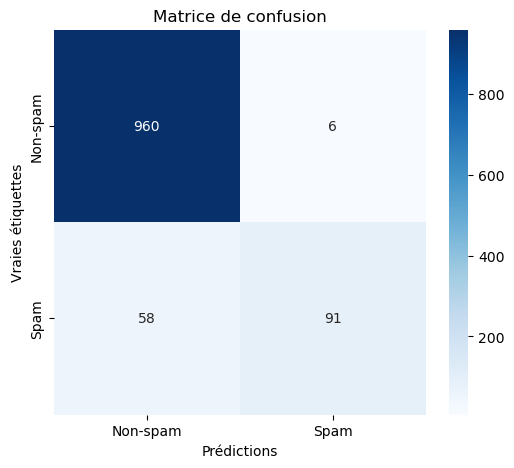

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(yt, pt)


labels = ['Non-spam', 'Spam']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

## 7. Conclusion

- Dataset **déséquilibré** : on privilégie aussi Precision/Recall/F1.
- Baseline EmbeddingBag : **très rapide** et souvent étonnamment performant.
- Améliorations possibles : n-grammes, BiLSTM, ou **transfer learning** (Transformers) si le contexte le permet.
- En production : calibration du seuil (coût FP/FN), monitoring de drift, retraining régulier.